# Train and validate the predict kidney failure model

In [1]:
# Load the training dataset

import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
data_path = os.getenv('TRAINING_DATA')
train = pd.read_csv(data_path)
train = train.dropna()
train = train.drop(columns = 'Studio')
train.shape

(3599, 19)

### Further preprocess the data

In [3]:
train.columns

Index(['Sesso', 'Diabete', 'ESRD', 'Eta1', 'Prot1', 'Creat1', 'Epi1',
       'Colesterolo1', 'Hb1', 'Ca1', 'P1', 'BMI1', 'ckd_cause_hypertens',
       'ckd_cause_diabet', 'ckd_cause_glom_dis', 'ckd_cause_tubul_inter',
       'ckd_cause_pkd', 'esrd_upper', 'esrd_lower'],
      dtype='object')

<Axes: xlabel='esrd_lower', ylabel='Count'>

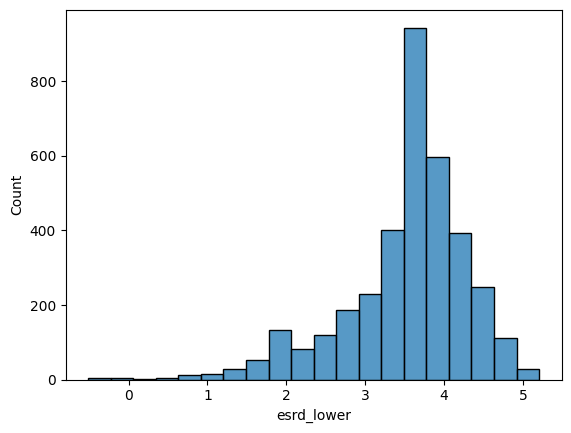

In [4]:
import seaborn as sns
import math

sns.histplot(np.log(train['esrd_lower']), bins=20)

<Axes: xlabel='esrd_lower', ylabel='Count'>

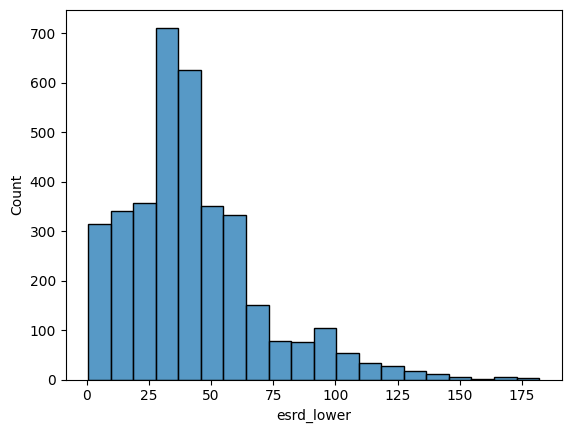

In [5]:
sns.histplot(train['esrd_lower'], bins=20)

In [6]:
print(train.columns)

Index(['Sesso', 'Diabete', 'ESRD', 'Eta1', 'Prot1', 'Creat1', 'Epi1',
       'Colesterolo1', 'Hb1', 'Ca1', 'P1', 'BMI1', 'ckd_cause_hypertens',
       'ckd_cause_diabet', 'ckd_cause_glom_dis', 'ckd_cause_tubul_inter',
       'ckd_cause_pkd', 'esrd_upper', 'esrd_lower'],
      dtype='object')


In [7]:
labelcols = {
    'lower': 'esrd_lower',
    'upper': 'esrd_upper'
}

In [8]:
# Import the results of the feature selection
import json

with open('raw_results/feature_selection_results.json') as f:
    var_dict = json.load(f)

In [9]:
df_feat_import = pd.DataFrame({'feat': var_dict['feat'], 'c_index': var_dict['c_index']})
df_feat_import['c_index'] = round(df_feat_import['c_index'], 2)
selected_feat = list(df_feat_import['feat'])[:np.argmax(df_feat_import['c_index']) + 3]
selected_feat

['Epi1', 'Prot1', 'BMI1', 'Eta1', 'P1', 'Ca1', 'Hb1', 'Colesterolo1']

In [10]:
train = train[list(selected_feat + [labelcols['lower'], labelcols['upper']])]

In [11]:
print(list(train.columns))

['Epi1', 'Prot1', 'BMI1', 'Eta1', 'P1', 'Ca1', 'Hb1', 'Colesterolo1', 'esrd_lower', 'esrd_upper']


In [12]:
train.rename(columns={'Epi1': 'EGFR', 
                      'Prot1': 'URIN_PROT', 
                      'BMI1': 'BMI', 
                      'Eta1': 'AGE', 
                      'P1': 'PHOSPHORUS', 
                      'Ca1': 'CALCIUM', 
                      'Hb1': 'HB', 
                      'Colesterolo1': 'CHOLESTEROL'}, inplace=True)

In [13]:
print(list(train.columns))

['EGFR', 'URIN_PROT', 'BMI', 'AGE', 'PHOSPHORUS', 'CALCIUM', 'HB', 'CHOLESTEROL', 'esrd_lower', 'esrd_upper']


In [14]:
best_params = var_dict['best_hyperparams'][np.argmax(df_feat_import['c_index'])+2]
best_params

['extreme', 0.1, [8, 10], 50, [1.0, 3.0]]

In [15]:
best_params = {'objective': 'survival:aft',
               'eval_metric': 'aft-nloglik',
               'aft_loss_distribution': 'extreme',
               'aft_loss_distribution_scale': 0.1,
               'tree_method': 'hist',
               'learning_rate': 0.01,
               'max_depth': [8,10],
               'booster': 'gbtree',
               'subsample': 1.0,
               'min_child_weight': 1.0,
               'colsample_bynode': 1.0,
               'n_models': 50,
               'subset_fraction': 1.0}

In [16]:
import bagging

model = bagging.BaggingXGBRegressor(params = best_params, 
                                    labelcols=labelcols, 
                                    verbose = True)

model.train(train, early_stopping_rounds=150, num_boost_round=1500, verbose_eval=500)

N duplicated samples: 1336 from 3599
[0]	train-aft-nloglik:27.62462	eval-aft-nloglik:27.60214


/Users/tamasszili-torok/Research/machine_learning/ESKD-predict/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[500]	train-aft-nloglik:4.11264	eval-aft-nloglik:7.34824
[1000]	train-aft-nloglik:0.38116	eval-aft-nloglik:4.49702
[1499]	train-aft-nloglik:0.37160	eval-aft-nloglik:4.14681
Model number : 1 out of 50

N duplicated samples: 1329 from 3599
[0]	train-aft-nloglik:27.61305	eval-aft-nloglik:27.61405
[500]	train-aft-nloglik:3.39594	eval-aft-nloglik:7.66350
[1000]	train-aft-nloglik:0.38063	eval-aft-nloglik:4.11305
[1499]	train-aft-nloglik:0.37741	eval-aft-nloglik:3.77119
Model number : 2 out of 50

N duplicated samples: 1361 from 3599
[0]	train-aft-nloglik:27.59799	eval-aft-nloglik:27.63102
[500]	train-aft-nloglik:3.86443	eval-aft-nloglik:7.53688
[1000]	train-aft-nloglik:0.35742	eval-aft-nloglik:4.27215
[1499]	train-aft-nloglik:0.35108	eval-aft-nloglik:3.96808
Model number : 3 out of 50

N duplicated samples: 1307 from 3599
[0]	train-aft-nloglik:27.62781	eval-aft-nloglik:27.59392
[500]	train-aft-nloglik:3.53535	eval-aft-nloglik:7.49232
[1000]	train-aft-nloglik:0.36950	eval-aft-nloglik:3.95715


### National validation
##### Import the national validation data, preprocessit and predict time to ESKD

In [17]:
#test = pd.read_csv('/Users/tamasszili-torok/Data/ckd_italy/time_to_eskd_prediction/test.csv')

nat_val_data_path = os.getenv('NATIONAL_VAL')
test = pd.read_csv(nat_val_data_path)
test = test.loc[test['Studio'] == 7]
test = test[list(selected_feat + [labelcols['lower'], labelcols['upper']])]
test.dropna(axis = 0, how = 'any', inplace = True)
test.shape

(346, 10)

In [18]:
test.columns

Index(['Epi1', 'Prot1', 'BMI1', 'Eta1', 'P1', 'Ca1', 'Hb1', 'Colesterolo1',
       'esrd_lower', 'esrd_upper'],
      dtype='object')

In [19]:
test.rename(columns={'Epi1': 'EGFR', 
                      'Prot1': 'URIN_PROT', 
                      'BMI1': 'BMI', 
                      'Eta1': 'AGE', 
                      'P1': 'PHOSPHORUS', 
                      'Ca1': 'CALCIUM', 
                      'Hb1': 'HB', 
                      'Colesterolo1': 'CHOLESTEROL'}, inplace=True)
test.columns

Index(['EGFR', 'URIN_PROT', 'BMI', 'AGE', 'PHOSPHORUS', 'CALCIUM', 'HB',
       'CHOLESTEROL', 'esrd_lower', 'esrd_upper'],
      dtype='object')

In [20]:
predicted_test = model.predict(test, output_margin = False)

# Aggregate the predictions
predicted_aggr = np.round(np.mean(predicted_test, axis = 0), 1)
predicted_ci = np.round(np.std(predicted_test, axis = 0) * 1.96, 1) 

In [21]:
import lifelines
print('National validation:\n')

event_times = test['esrd_lower'].to_numpy()
event_observed = (test['esrd_upper'] == test['esrd_lower']).astype(int).to_numpy()
print('Model performance (c-index): ' + str(round(lifelines.utils.concordance_index(event_times, predicted_aggr, event_observed),3)) + '\n')

print('Median of time to ESRD development: ' + str(round(np.median(event_times[np.where(event_observed == 1)]), 1)) + 
      '. Median of predicted time to ESRD development: ' + str(round(np.median(predicted_aggr[np.where(event_observed == 1)]), 1)))
print('Median time for censored cases: ' + str(round(np.median(event_times[np.where(event_observed == 0)]), 1)) + 
          '. Median time predicted for censored cases: ' + str(round(np.median(predicted_aggr[np.where(event_observed == 0)]), 1)))
print('Median overall time: ' + str(round(np.median(event_times), 1)) + 
          '. Median overall predicted time: ' + str(round(np.median(predicted_aggr), 1)))

National validation:

Model performance (c-index): 0.849

Median of time to ESRD development: 31.3. Median of predicted time to ESRD development: 32.7
Median time for censored cases: 61.8. Median time predicted for censored cases: 104.1
Median overall time: 51.5. Median overall predicted time: 75.1


## International validation
##### Import the international validation data (from the UMCG), preprocess it and predict time to ESKD

In [22]:
intl_val_data_path = os.getenv('INTL_VAL')
test_intl = pd.read_csv(intl_val_data_path)
test_intl = test_intl.drop(columns = 'ID_UMCG')
test_intl.shape

(368, 10)

In [23]:
test_intl.rename(columns={'Epi1': 'EGFR',
                          'Proteinurieurine': 'URIN_PROT',
                          'bmi': 'BMI',
                          'age': 'AGE',
                          'Fosfaat': 'PHOSPHORUS',
                          'Calciumbloed': 'CALCIUM',
                          'Hbmmolperliter': 'HB',
                          'totaalcholesterol': 'CHOLESTEROL'}, inplace=True)
test_intl = test_intl[train.columns]
test_intl.columns

Index(['EGFR', 'URIN_PROT', 'BMI', 'AGE', 'PHOSPHORUS', 'CALCIUM', 'HB',
       'CHOLESTEROL', 'esrd_lower', 'esrd_upper'],
      dtype='object')

In [24]:
test_intl = test_intl[test.columns]
test_intl.dropna(axis = 0, how = 'any', inplace = True)
test_intl.shape

(297, 10)

In [25]:
# Convert features into the correct units
# https://www.ukkidney.org/sites/renal.org/files/Appendix-I_0.pdf
test_intl['PHOSPHORUS'] = test_intl['PHOSPHORUS'] * 3.1
test_intl['CALCIUM'] = test_intl['CALCIUM'] * 4
test_intl['CHOLESTEROL'] = test_intl['CHOLESTEROL'] * 38.6
# https://www.unitsconverters.com/en/Mmol/L-To-G/Dl/Utu-6013-6012
test_intl['HB'] = test_intl['HB'] * 1.6113

In [26]:
predicted_test_intl = model.predict(test_intl, output_margin = False)

# Aggregate the predictions
predicted_aggr_intl = np.round(np.mean(predicted_test_intl, axis = 0), 1)
predicted_ci_intl = np.round(np.std(predicted_test_intl, axis = 0) * 1.96, 1) 

In [27]:

event_times_intl = test_intl['esrd_lower'].to_numpy()
event_observed_intl = (test_intl['esrd_upper'] == test_intl['esrd_lower']).astype(int).to_numpy()

print('International validation:\n')

print('Model performance (c-index): ' + str(round(lifelines.utils.concordance_index(event_times_intl, predicted_aggr_intl, event_observed_intl),3)) + '\n')

print('Median of time to ESRD development: ' + str(round(np.median(event_times_intl[np.where(event_observed_intl == 1)]), 1)) + 
      '. Median of predicted time to ESRD development: ' + str(round(np.median(predicted_aggr_intl[np.where(event_observed_intl == 1)]), 1)))
print('Median time for censored cases: ' + str(round(np.median(event_times_intl[np.where(event_observed_intl == 0)]), 1)) + 
          '. Median time predicted for censored cases: ' + str(round(np.median(predicted_aggr_intl[np.where(event_observed_intl == 0)]), 1)))
print('Median overall time: ' + str(round(np.median(event_times_intl), 1)) + 
          '. Median overall predicted time: ' + str(round(np.median(predicted_aggr_intl), 1)))

International validation:

Model performance (c-index): 0.877

Median of time to ESRD development: 51.5. Median of predicted time to ESRD development: 43.4
Median time for censored cases: 120.3. Median time predicted for censored cases: 111.2
Median overall time: 85.8. Median overall predicted time: 90.7


### Visualize model performance and model calibration

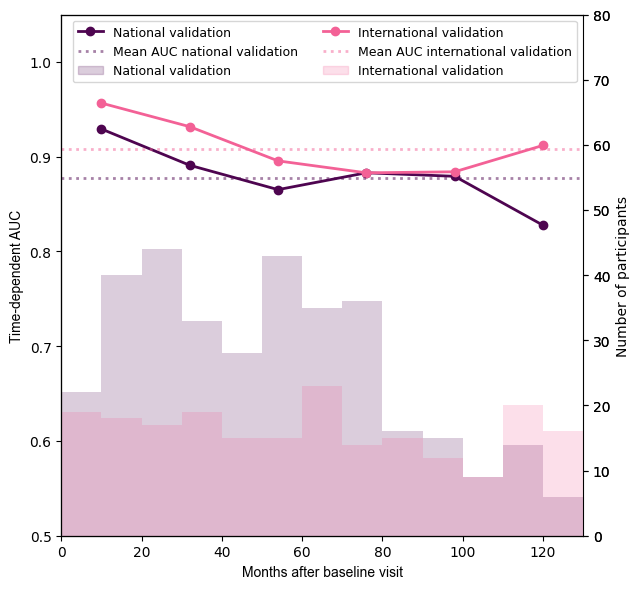

In [28]:
from sksurv.metrics import (
    as_concordance_index_ipcw_scorer,
    as_cumulative_dynamic_auc_scorer,
    as_integrated_brier_score_scorer,
)

from sksurv import metrics as sksurvmetrics
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

event_observed_train = (train['esrd_upper'] == train['esrd_lower']).astype(bool).to_numpy()
event_observed_test = (test['esrd_upper'] == test['esrd_lower']).astype(bool).to_numpy()

# The survival times need to be negative in order to transform them into a risk score.
auc_nat, mean_auc_nat = sksurvmetrics.cumulative_dynamic_auc(np.array(list(zip(event_observed_train, train['esrd_lower'])), dtype=[('event', '?'), ('time', '<f8')]), 
                                                     np.array(list(zip(event_observed_test, test['esrd_lower'])), dtype=[('event', '?'), ('time', '<f8')]), 
                                                     -predicted_aggr, 
                                                     np.linspace(10, 120, 6)
                                                    )

# The survival times need to be negative in order to transform them into a risk score.
auc_intl, mean_auc_intl = sksurvmetrics.cumulative_dynamic_auc(np.array(list(zip(event_observed_train, train['esrd_lower'])), dtype=[('event', '?'), ('time', '<f8')]), 
                                                     np.array(list(zip(event_observed_intl, test_intl['esrd_lower'])), dtype=[('event', '?'), ('time', '<f8')]), 
                                                     -predicted_aggr_intl, 
                                                     np.linspace(10, 120, 6)
                                                    )

fig, ax = plt.subplots(figsize = (6.5, 6.0))

ax_density_nat = ax.twinx()
ax_density_intl = ax.twinx()

sns.histplot(event_times, fill=True, color='xkcd:plum purple', linewidth = 0.0, alpha=0.20, bins = np.linspace(0, 180, 19), ax=ax_density_nat, zorder=1)
sns.histplot(event_times_intl, fill=True, color='xkcd:medium pink', linewidth = 0.0, alpha=0.20, bins = np.linspace(0, 180, 19), ax=ax_density_intl, zorder=1)

ax_density_nat.set_yticks(np.linspace(0,80, 9))
ax_density_nat.spines['right'].set_visible(False)
ax_density_nat.set_ylabel('')

ax_density_intl.set_yticks(np.linspace(0,80, 9))
ax_density_intl.spines['right'].set_visible(False)
ax_density_intl.set_ylabel('Number of participants')

line1, = ax.plot(np.linspace(10, 120, 6), auc_nat, label = 'National validation', marker="o", color = 'xkcd:plum purple', linewidth = 2.0)
line2, = ax.plot(np.linspace(10, 120, 6), auc_intl, label = 'International validation', marker="o", color = 'xkcd:medium pink', linewidth = 2.0)
ax.set_ylim(0.5,1.05)
ax.set_xlim(0.0,130.0)
ax.set_xlabel("Months after baseline visit", fontname = 'arial')
ax.set_ylabel("Time-dependent AUC", fontname = 'arial')
line3, = ax.plot([0, 130], [mean_auc_nat, mean_auc_nat], label = 'Mean AUC national validation', linestyle = "dotted", color = 'xkcd:plum purple', alpha = 0.5, linewidth = 2.0)
line4, = ax.plot([0, 130], [mean_auc_intl, mean_auc_intl], label = 'Mean AUC international validation', linestyle = "dotted", color = 'xkcd:medium pink', alpha = 0.5, linewidth = 2.0)

nat_patch = Patch(color='xkcd:plum purple', alpha=0.20, label='National validation')
intl_patch = Patch(color='xkcd:medium pink', alpha=0.20, label='International validation')
ax.legend(ncols = 2,handles=[line1, line3, nat_patch, line2, line4,  intl_patch], loc='upper right', fontsize = 9)

plt.tight_layout()
plt.savefig("figures/figure_2.pdf")
plt.show()

In [29]:
def count_has_less_than_min_cases(counts, min_cases):
    return any(counts < min_cases)

def merge_intervals(interval1, interval2):
    return pd.Interval(left=min(interval1.left, interval2.left), right=max(interval1.right, interval2.right), closed='both')

def merge_small_bins(df, column, min_cases):
    
    counts = df[column].value_counts(sort=True)
    
    counts = counts[counts != 0]
    counts = counts.sort_index(ascending = False)
    indices = counts.index
    index_right = indices[0].right
    new_bins = []

    while count_has_less_than_min_cases(counts, min_cases):
        i = 0
        for index, count in counts.items():
            if count < min_cases:
                if i == len(counts):
                    merge_with_interval = counts.index[i-1]
                else:
                    merge_with_interval = counts.index[i+1]
                    
                new_interval = merge_intervals(interval1 = merge_with_interval, interval2 = index)
                new_count = count + counts[merge_with_interval]
                add_series = pd.Series([new_count], index = [new_interval])
                counts = counts.drop([merge_with_interval, index])
                counts = pd.concat([add_series, counts])
                break
            else:
                i += 1
                
    print('New splits:\n' + str(counts.sort_index(ascending = True)))

    left_bounds = [interval.left for interval in counts.index]
    right_bounds = [interval.right for interval in counts.index]
    all_bounds = sorted(set(left_bounds + right_bounds))
    df[column] = pd.cut(df['real'], bins = all_bounds)
    
    return df, all_bounds

New splits:
(0.0, 20.0]      43
(20.0, 40.0]     34
(40.0, 60.0]     30
(60.0, 80.0]     14
[80.0, 120.0]     8
dtype: int64
New splits:
(0.0, 20.0]       28
(20.0, 40.0]      19
(40.0, 60.0]      19
(60.0, 80.0]      17
(80.0, 100.0]     13
(100.0, 120.0]    10
[120.0, 180.0]     8
dtype: int64


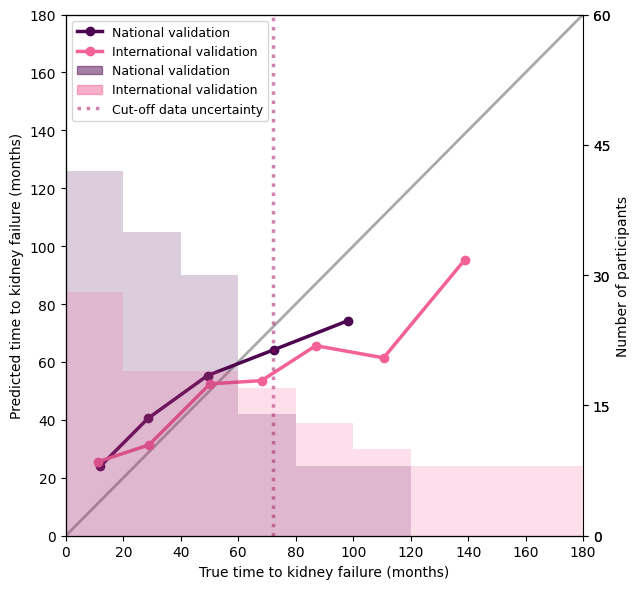

In [30]:
df_plot = pd.DataFrame({'real': event_times[np.where(event_observed == 1)], 'predicted': predicted_aggr[np.where(event_observed == 1)]})
df_plot['calibration_bins'] = pd.cut(df_plot['real'], bins = np.linspace(0,180,10))
df_plot, bins_nat = merge_small_bins(df_plot, 'calibration_bins', min_cases=5)
mean_real = df_plot.groupby('calibration_bins', observed = True)['real'].mean().to_numpy()
mean_predicted = df_plot.groupby('calibration_bins', observed = True)['predicted'].mean().to_numpy()

df_plot_intl = pd.DataFrame({'real': event_times_intl[np.where(event_observed_intl == 1)], 'predicted': predicted_aggr_intl[np.where(event_observed_intl == 1)]})
df_plot_intl['calibration_bins'] = pd.cut(df_plot_intl['real'], bins = np.linspace(0,180,10))
df_plot_intl, bins_intl = merge_small_bins(df_plot_intl, 'calibration_bins', min_cases=5)
mean_real_intl = df_plot_intl.groupby('calibration_bins', observed = True)['real'].mean().to_numpy()
mean_predicted_intl = df_plot_intl.groupby('calibration_bins', observed = True)['predicted'].mean().to_numpy()

fig, ax = plt.subplots(figsize = (6.5, 6.0))

ax_density_nat = ax.twinx()
ax_density_intl = ax.twinx()

sns.histplot(event_times[np.where(event_observed == 1)], fill=True, color='xkcd:plum purple', linewidth = 0.0, alpha=0.20, ax=ax_density_nat, bins = bins_nat, zorder=1)
sns.histplot(event_times_intl[np.where(event_observed_intl == 1)], fill=True, color='xkcd:medium pink', linewidth = 0.0, alpha=0.20, ax=ax_density_intl, bins = bins_intl, zorder=1)

ax_density_nat.set_yticks(np.linspace(0,60, 5))
ax_density_nat.spines['right'].set_visible(False)
#ax_density_nat.set_ylim(0, 100)
ax_density_nat.set_ylabel('')

ax_density_intl.set_yticks(np.linspace(0,60, 5))
ax_density_intl.spines['right'].set_visible(False)
#ax_density_intl.set_ylim(0, 100)
ax_density_intl.set_ylabel('Number of participants')

ax.plot([0, 180], [0, 180], color = "darkgray", linestyle = "-", linewidth = 2.0, zorder = 1)
line1, = ax.plot(mean_real, mean_predicted, label = 'National validation', marker = "o", linestyle = "-", color = 'xkcd:plum purple', linewidth = 2.5, zorder = 2)
line2, = ax.plot(mean_real_intl, mean_predicted_intl, label = 'International validation', marker = "o", linestyle = "-", color = 'xkcd:medium pink', linewidth = 2.5, zorder = 2)
line3, = ax.plot([72, 72], [0, 180], label = 'Cut-off data uncertainty', color = "xkcd:dark fuchsia", linestyle = "dotted", linewidth = 2.5, alpha = 0.5, zorder = 2)
ax.set_xlim(0, 180)
ax.set_ylim(0, 180)
ax.set_xlabel("True time to kidney failure (months)")
ax.set_ylabel("Predicted time to kidney failure (months)")

nat_patch = Patch(color='xkcd:plum purple', alpha=0.5, label='National validation')
intl_patch = Patch(color='xkcd:medium pink', alpha=0.5, label='International validation')
ax.legend(handles=[line1, line2, nat_patch, intl_patch, line3], loc='upper left', fontsize = 9)

plt.tight_layout()
plt.savefig("figures/figure_3.pdf")
plt.show()

### Explain the model using Shapley values

In [31]:
selected_feat

['Epi1', 'Prot1', 'BMI1', 'Eta1', 'P1', 'Ca1', 'Hb1', 'Colesterolo1']

In [32]:
test_merged = pd.concat([test, test_intl])

In [33]:
col_names_shap = ['eGFR', 'Proteinuria', 'Body mass index', 'Age', 'Plasma phosphorus',  'Calcium', 
                  'Hemoglobin', 'Total cholesterol' 
                   ]
col_names_shap_units = ['eGFR (mL/min/1.73m$^{2}$)', 'Proteinuria (g/day)', 'Body mass index (kg/m$^{2}$)', 'Age (years)', 
                        'Plasma phosphorus (mg/dL)', 'Calcium (mg/dL)', 'Hemoglobin (g/dL)', 'Total cholesterol (mg/dL)'
                   ]
df_feature_dict = pd.DataFrame({'feat_name_in_df': test_merged.drop(columns = ['esrd_lower', 'esrd_upper']).columns, 'feat_name': col_names_shap, 'feat_name_unit': col_names_shap_units})
df_feature_dict

,feat_name_in_df,feat_name,feat_name_unit
0,EGFR,eGFR,eGFR (mL/min/1.73m$^{2}$)
1,URIN_PROT,Proteinuria,Proteinuria (g/day)
2,BMI,Body mass index,Body mass index (kg/m$^{2}$)
3,AGE,Age,Age (years)
4,PHOSPHORUS,Plasma phosphorus,Plasma phosphorus (mg/dL)
5,CALCIUM,Calcium,Calcium (mg/dL)
6,HB,Hemoglobin,Hemoglobin (g/dL)
7,CHOLESTEROL,Total cholesterol,Total cholesterol (mg/dL)


In [34]:
import shap
import xgboost as xgb
from typing import Optional

shap_vals = model.feature_importances(importance_type = 'shap')

test_shap = test_merged.drop(columns=labelcols.values())
shap_val_average = []
expected_val: Optional[float] = None

shap_val_average = np.median(np.array([ s.shap_values(test_shap) for s in shap_vals ]), axis=0)
expected_val = np.median([ s.expected_value for s in shap_vals ])

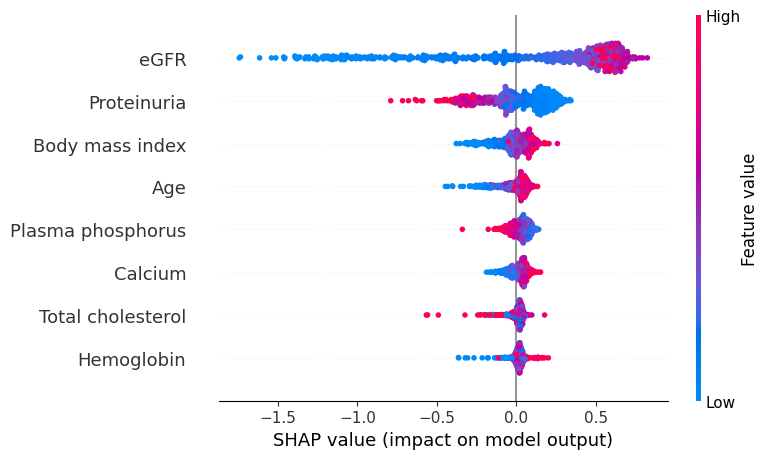

In [35]:
fig, ax = plt.subplots()
shap.summary_plot(shap_val_average, test_shap, feature_names = col_names_shap, max_display = 20)
fig.savefig("figures/figure_4.pdf")

In [36]:
predicted_test_merged = model.predict(test_merged, output_margin = False)

# Aggregate the predictions
predicted_aggr_merged = np.round(np.mean(predicted_test_merged, axis = 0), 1)
predicted_ci_merged = np.round(np.std(predicted_test_merged, axis = 0) * 1.96, 1)

predictions_formatted = [f"{predicted_aggr_merged:.1f}±{predicted_ci_merged:.1f}" for predicted_aggr_merged, predicted_ci_merged in zip(predicted_aggr_merged, predicted_ci_merged)]

labels = pd.DataFrame({
    'index': list(range(0, len(test_merged['esrd_lower']))),
    'lower': np.round(test_merged['esrd_lower'], 1),
    'upper': np.round(test_merged['esrd_upper'], 1),
    'predicted_mean_ci': predictions_formatted
})


In [37]:
import math
import seaborn as sns
def shap_bar_plot_sns(feature_names, shap_values, feature_values, xlabel = True):
    shap_df = pd.DataFrame({'feat_names': feature_names, 'shap_values': shap_values, 'feat_values': feature_values.tolist()[:8]})
    col_list = list()
    diff_list = []
    names_list = []
    values_list = []
    for i, val in enumerate(shap_df['shap_values']):
        diff_list.append(math.dist([val], [0.0]))
        values_list.append(round(feature_values.tolist()[:8][i], 2))
        names_list.append(f"{feature_names[i]}")
        if val > 0:
            col_list.append("#008BFB")
        else:
            col_list.append("#ff0454")
    shap_df['color'] = np.array(col_list)
    shap_df['names'] = np.array(names_list)
    shap_df = shap_df.set_index('feat_names').reindex(col_names_shap_units)
    ax = sns.barplot(x=shap_df['shap_values'], 
                     y=shap_df['names'], 
                     palette = list(shap_df['color']), 
                     hue=shap_df['names'], 
                     legend = False, 
                     saturation = 1)
    ax.axes.set_title("",fontsize=8)
    sns.despine()
    for i, container in enumerate(ax.containers):
        ax.bar_label(container, labels = [values_list[i]], padding = 5)
    if xlabel:
        ax.set(xlabel='SHAP value (impact on model output)', ylabel=None)
    else:
        ax.set(xlabel=None, ylabel=None)
    
    return ax

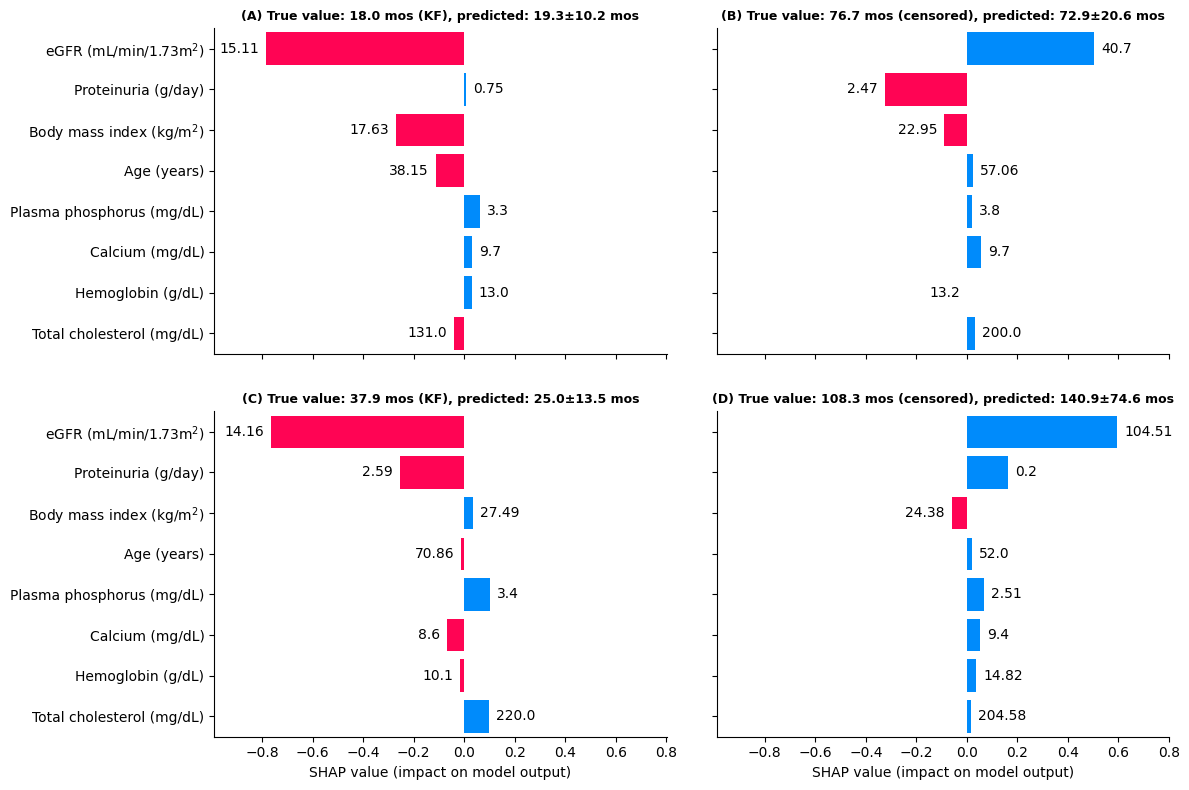

In [38]:
fig = plt.figure(figsize=(12, 8))

rows = 2
columns = 2
font_size = 9

ax_1 = fig.add_subplot(rows, columns, 1) 
fig_1 = shap_bar_plot_sns(col_names_shap_units, shap_val_average[2], test_merged.iloc[2], xlabel = False).get_figure()
plt.title(f"(A) True value: {round(test_merged.iloc[2][labelcols['lower']],1)} mos ({'KF' if test_merged.iloc[2][labelcols['lower']] == test_merged.iloc[2][labelcols['upper']] else 'censored'}), predicted: {labels['predicted_mean_ci'].iloc[2]} mos",
         fontsize = font_size, fontweight = 'semibold')

ax_2 = fig.add_subplot(rows, columns, 2, sharex = ax_1, sharey = ax_1)
fig_2 = shap_bar_plot_sns(col_names_shap_units, shap_val_average[51], test_merged.iloc[51], xlabel = False).get_figure()
plt.title(f"(B) True value: {round(test_merged.iloc[51][labelcols['lower']],1)} mos ({'KF' if test_merged.iloc[51][labelcols['lower']] == test_merged.iloc[80][labelcols['upper']] else 'censored'}), predicted: {labels['predicted_mean_ci'].iloc[51]} mos",
         fontsize = font_size, fontweight = 'semibold')

ax_3 = fig.add_subplot(rows, columns, 3, sharex = ax_1, sharey = ax_1)
fig_3 = shap_bar_plot_sns(col_names_shap_units, shap_val_average[311], test_merged.iloc[311]).get_figure()
plt.title(f"(C) True value: {round(test_merged.iloc[311][labelcols['lower']],1)} mos ({'KF' if test_merged.iloc[311][labelcols['lower']] == test_merged.iloc[311][labelcols['upper']] else 'censored'}), predicted: {labels['predicted_mean_ci'].iloc[311]} mos",
         fontsize = font_size, fontweight = 'semibold')

ax_4 = fig.add_subplot(rows, columns, 4, sharex = ax_1, sharey = ax_1)
fig_4 = shap_bar_plot_sns(col_names_shap_units, shap_val_average[635], test_merged.iloc[635]).get_figure()
plt.title(f"(D) True value: {round(test_merged.iloc[635][labelcols['lower']],1)} mos ({'KF' if test_merged.iloc[635][labelcols['lower']] == test_merged.iloc[635][labelcols['upper']] else 'censored'}), predicted: {labels['predicted_mean_ci'].iloc[635]} mos",
         fontsize = font_size, fontweight = 'semibold')

ax_1.margins(x=0.15)
ax_1.tick_params(labelbottom = False)
ax_2.tick_params(labelbottom = False)
ax_2.tick_params(labelleft = False)
ax_4.tick_params(labelleft = False)
fig.tight_layout(h_pad=2.5, w_pad=2.5)
fig.savefig("figures/figure_5.pdf")

In [40]:
# Save the models and some raw data
model_path = os.getenv('MODEL')
model.save(model_path)
pd.DataFrame(shap_val_average).to_csv('raw_results/model_validation_shap_val.csv', index = False)
labels.to_csv('raw_results/model_predicted_real_values.csv', index = False)